In [3]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [4]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=1e208221d0e9e53083f49b2ff8f9fd4f02615b6adf4534b3a52cd8648627982b
  Stored in directory: /root/.cache/pip/wheels/b9/c6/5a/829298789e94348b81af52ab42c19d49da007306bbcc983827
Successfully built pandarallel


In [5]:
!pip install polars plotly pyarrow scikit-learn colorama tqdm

EXPLORATORY DATA ANALYSIS:


IMPORTS:

In [6]:
import gc 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import polars as pl
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init

import pyarrow as pa
import datetime as dt
import torch

from tqdm import tqdm
tqdm.pandas()

from pyarrow.parquet import ParquetFile
from datetime import datetime as dts
from pandarallel import pandarallel 
pandarallel.initialize(progress_bar=True)


import warnings
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


LOADING DATA:

In [7]:
class PATHS:
    MAIN_DIR = "/kaggle/input/child-mind-institute-detect-sleep-states/"
    # CSV FILES : 
    SUBMISSION = MAIN_DIR + "sample_submission.csv"
    TRAIN_EVENTS = MAIN_DIR + "train_events.csv"
    # PARQUET FILES:
    TRAIN_SERIES = MAIN_DIR + "train_series.parquet"
    TEST_SERIES = MAIN_DIR + "test_series.parquet"

In [8]:
class CFG:
    DEMO_MODE = True
    VERBOSE = True
    
    BATCH_SIZE = 32
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class CMIDataReader:
    def __init__(self, demo_mode, verbose):
        super().__init__()
        # MAPPING FOR DATA LOADING :
        self.names_mapping = {
            "submission" : {"path" : PATHS.SUBMISSION, "is_parquet" : False, "has_timestamp" : False}, 
            "train_events" : {"path" : PATHS.TRAIN_EVENTS, "is_parquet" : False, "has_timestamp" : True},
            "train_series" : {"path" : PATHS.TRAIN_SERIES, "is_parquet" : True, "has_timestamp" : True},
            "test_series" : {"path" : PATHS.TEST_SERIES, "is_parquet" : True, "has_timestamp" : True}
        }
        self.valid_names = ["submission", "train_events", "train_series", "test_series"]
        self.demo_mode = demo_mode
        self.verbose = verbose
    
    def verify(self, data_name):
        "function for data name verification"
        if data_name not in self.valid_names:
            print("PLEASE ENTER A VALID DATASET NAME, VALID NAMES ARE : ", valid_names)
        return
    
    def cleaning(self, data):
        "cleaning function : drop na values"
        before_cleaning = len(data)
        if self.verbose:
            print("Number of missing timestamps : ", len(data[data["timestamp"].isna()]))
        data = data.dropna(subset=["timestamp"])
        after_cleaning = len(data)
        if self.verbose:
            print("Percentage of removed rows : {:.1f}%".format(100 * (before_cleaning - after_cleaning) / before_cleaning) )
        data = data.bfill()
        return data
    
    def reduce_memory_usage(self, data):
        "iterate through all the columns of a dataframe and modify the data type to reduce memory usage."
        start_mem = data.memory_usage().sum() / 1024**2
        if self.verbose:
            print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in data.columns:
            col_type = data[col].dtype    
            if col_type != object:
                c_min = data[col].min()
                c_max = data[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        data[col] = data[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        data[col] = data[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        data[col] = data[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        data[col] = data[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        data[col] = data[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        data[col] = data[col].astype(np.float32)
                    else:
                        data[col] = data[col].astype(np.float64)
            else:
                data[col] = data[col].astype('category')

        end_mem = data.memory_usage().sum() / 1024**2
        if self.verbose:
            print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
            print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return data
    
    def load_data(self, data_name):
        "function for data loading"
        self.verify(data_name)
        data_props = self.names_mapping[data_name]
        if data_props["is_parquet"]:
            if self.demo_mode:
                pf = ParquetFile(data_props["path"]) 
                demo_rows = next(pf.iter_batches(batch_size=10_000_000)) 
                data = pa.Table.from_batches([demo_rows]).to_pandas()
            else:
                data = pd.read_parquet(data_props["path"])
        else:
            if self.demo_mode:
                data = pd.read_csv(data_props["path"], nrows=10_000_000)
            else:
                data = pd.read_csv(data_props["path"])
        
        if data_props["has_timestamp"]:
            data = self.cleaning(data)
            data["timestamp"] = pd.to_datetime(data["timestamp"])
            data = data.set_index("timestamp")
        
        data = self.reduce_memory_usage(data)
        gc.collect()
        return data

In [10]:
reader = CMIDataReader(demo_mode=CFG.DEMO_MODE, verbose=CFG.VERBOSE)

In [11]:
print("="*25)
print("LOAD SUBMISSION")
submission = reader.load_data("submission")
print(submission.head(10))
print("LOADING FINISHED ! ")
print("="*25)

LOAD SUBMISSION
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -14.0%
   row_id     series_id  step   event  score
0       0  038441c925bb   100   onset    0.0
1       1  038441c925bb   105  wakeup    0.0
2       2  03d92c9f6f8a    80   onset    0.5
3       3  03d92c9f6f8a   110  wakeup    0.5
4       4  0402a003dae9    90   onset    1.0
5       5  0402a003dae9   120  wakeup    1.0
LOADING FINISHED ! 


In [15]:
print("LOAD TEST SERIES")
test_series = reader.load_data("test_series")
print(test_series.head(10))
print("LOADING FINISHED ! ")
print("="*25)

LOAD TEST SERIES
Number of missing timestamps :  0
Percentage of removed rows : 0.0%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 45.4%
                              series_id  step    anglez      enmo
timestamp                                                        
2018-08-14 15:30:00-04:00  038441c925bb   0.0  2.636719  0.021698
2018-08-14 15:30:05-04:00  038441c925bb   1.0  2.636719  0.021500
2018-08-14 15:30:10-04:00  038441c925bb   2.0  2.636719  0.021606
2018-08-14 15:30:15-04:00  038441c925bb   3.0  2.636719  0.021301
2018-08-14 15:30:20-04:00  038441c925bb   4.0  2.636719  0.021500
2018-08-14 15:30:25-04:00  038441c925bb   5.0  2.636719  0.021698
2018-08-14 15:30:30-04:00  038441c925bb   6.0  2.636719  0.021698
2018-08-14 15:30:35-04:00  038441c925bb   7.0  2.636719  0.021805
2018-08-14 15:30:40-04:00  038441c925bb   8.0  2.798828  0.022293
2018-08-14 15:30:45-04:00  038441c925bb   9.0  3.083984  0.021698
LOADING FINISHED ! 


In [16]:
%time
print("="*25)
print("LOAD TRAIN SERIES")
train_series = reader.load_data("train_series")
print(train_series.head(10))
print("LOADING FINISHED ! ")
print("="*25)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
LOAD TRAIN SERIES
Number of missing timestamps :  0
Percentage of removed rows : 0.0%
Memory usage of dataframe is 267.03 MB
Memory usage after optimization is: 162.13 MB
Decreased by 39.3%
                              series_id  step    anglez      enmo
timestamp                                                        
2018-08-14 15:30:00-04:00  038441c925bb   0.0  2.636719  0.021698
2018-08-14 15:30:05-04:00  038441c925bb   1.0  2.636719  0.021500
2018-08-14 15:30:10-04:00  038441c925bb   2.0  2.636719  0.021606
2018-08-14 15:30:15-04:00  038441c925bb   3.0  2.636719  0.021301
2018-08-14 15:30:20-04:00  038441c925bb   4.0  2.636719  0.021500
2018-08-14 15:30:25-04:00  038441c925bb   5.0  2.636719  0.021698
2018-08-14 15:30:30-04:00  038441c925bb   6.0  2.636719  0.021698
2018-08-14 15:30:35-04:00  038441c925bb   7.0  2.636719  0.021805
2018-08-14 15:30:40-04:00  038441c925bb   8.0  2.798828  0.022293
2018-08-14 15:30:45-

In [17]:
%time
print("="*25)
print("LOAD TRAIN EVENTS")
train_events = reader.load_data("train_events")
print(train_events.head(10))
print("LOADING FINISHED ! ")
print("="*25)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
LOAD TRAIN EVENTS
Number of missing timestamps :  4923
Percentage of removed rows : 33.9%
Memory usage of dataframe is 0.37 MB
Memory usage after optimization is: 0.16 MB
Decreased by 57.2%
                              series_id  night   event     step
timestamp                                                      
2018-08-14 22:26:00-04:00  038441c925bb      1   onset   4992.0
2018-08-15 06:41:00-04:00  038441c925bb      1  wakeup  10932.0
2018-08-15 19:37:00-04:00  038441c925bb      2   onset  20244.0
2018-08-16 05:41:00-04:00  038441c925bb      2  wakeup  27492.0
2018-08-16 23:03:00-04:00  038441c925bb      3   onset  39996.0
2018-08-17 05:10:00-04:00  038441c925bb      3  wakeup  44400.0
2018-08-17 23:00:00-04:00  038441c925bb      4   onset  57240.0
2018-08-18 06:48:00-04:00  038441c925bb      4  wakeup  62856.0
2018-08-19 22:18:00-04:00  038441c925bb      6   onset  91296.0
2018-08-20 07:25:00-04:00  038441c925bb   

DATA STATISTICS:

In [18]:
train_series.describe().T

,count,mean,std,min,25%,50%,75%,max
step,10000000.0,245794.890625,162514.390625,0.0,113636.00000,227272.000000,348818.250000,778679.000000
anglez,10000000.0,NaN,0.000000,-90.0,-30.65625,-6.734375,15.742188,89.750000
enmo,10000000.0,NaN,0.000000,0.0,0.00090,0.014900,0.039612,5.097656


In [19]:
train_events.describe().T

,count,mean,std,min,25%,50%,75%,max
night,9585.0,12.861555,8.168517,1.0,6.0,12.0,19.0,43.0
step,9585.0,214352.125000,141268.312500,936.0,95436.0,200604.0,317520.0,739392.0


In [20]:
print('='*25)
print(train_series.info())
print('='*25)
print(train_events.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10000000 entries, 2018-08-14 15:30:00-04:00 to 2019-02-03 09:53:15-05:00
Data columns (total 4 columns):
 #   Column     Dtype   
---  ------     -----   
 0   series_id  category
 1   step       float32 
 2   anglez     float16 
 3   enmo       float16 
dtypes: category(1), float16(2), float32(1)
memory usage: 162.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9585 entries, 2018-08-14 22:26:00-04:00 to 2017-09-07 09:17:00-04:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   series_id  9585 non-null   category
 1   night      9585 non-null   int8    
 2   event      9585 non-null   category
 3   step       9585 non-null   float32 
dtypes: category(2), float32(1), int8(1)
memory usage: 160.1+ KB
None


In [21]:
print("\nTrain Events Dataset Info:")
print(f"Shape: {train_events.shape}")

print("\nTrain Series Dataset Info:")
print(f"Shape: {train_series.shape}")

print("\nTest Series Dataset Info:")
print(f"Shape: {test_series.shape}")



Train Events Dataset Info:
Shape: (9585, 4)

Train Series Dataset Info:
Shape: (10000000, 4)

Test Series Dataset Info:
Shape: (450, 4)


In [22]:
train_series.reset_index(inplace = True)
train_events.reset_index(inplace = True)

In [23]:
train_series

,timestamp,series_id,step,anglez,enmo
0,2018-08-14 15:30:00-04:00,038441c925bb,0.0,2.636719,0.021698
1,2018-08-14 15:30:05-04:00,038441c925bb,1.0,2.636719,0.021500
2,2018-08-14 15:30:10-04:00,038441c925bb,2.0,2.636719,0.021606
3,2018-08-14 15:30:15-04:00,038441c925bb,3.0,2.636719,0.021301
4,2018-08-14 15:30:20-04:00,038441c925bb,4.0,2.636719,0.021500
...,...,...,...,...,...
9999995,2019-02-03 09:52:55-05:00,12d01911d509,431195.0,41.093750,0.114807
9999996,2019-02-03 09:53:00-05:00,12d01911d509,431196.0,19.218750,0.088806
9999997,2019-02-03 09:53:05-05:00,12d01911d509,431197.0,15.171875,0.123901
9999998,2019-02-03 09:53:10-05:00,12d01911d509,431198.0,8.773438,0.125244


In [24]:
train_events

,timestamp,series_id,night,event,step
0,2018-08-14 22:26:00-04:00,038441c925bb,1,onset,4992.0
1,2018-08-15 06:41:00-04:00,038441c925bb,1,wakeup,10932.0
2,2018-08-15 19:37:00-04:00,038441c925bb,2,onset,20244.0
3,2018-08-16 05:41:00-04:00,038441c925bb,2,wakeup,27492.0
4,2018-08-16 23:03:00-04:00,038441c925bb,3,onset,39996.0
...,...,...,...,...,...
9580,2017-09-05 09:26:00-04:00,fe90110788d2,32,wakeup,547152.0
9581,2017-09-05 22:30:00-04:00,fe90110788d2,33,onset,556560.0
9582,2017-09-06 04:07:00-04:00,fe90110788d2,33,wakeup,560604.0
9583,2017-09-06 23:35:00-04:00,fe90110788d2,34,onset,574620.0


In [25]:
# Ensure it's in datetime format
train_events["timestamp"] = pd.to_datetime(train_events["timestamp"], utc = True)

# Extract datetime components
train_events["year"] = train_events["timestamp"].dt.year
train_events["month"] = train_events["timestamp"].dt.month
train_events["day"] = train_events["timestamp"].dt.day
train_events["hour"] = train_events["timestamp"].dt.hour

In [26]:
train_events

,timestamp,series_id,night,event,step,year,month,day,hour
0,2018-08-15 02:26:00+00:00,038441c925bb,1,onset,4992.0,2018,8,15,2
1,2018-08-15 10:41:00+00:00,038441c925bb,1,wakeup,10932.0,2018,8,15,10
2,2018-08-15 23:37:00+00:00,038441c925bb,2,onset,20244.0,2018,8,15,23
3,2018-08-16 09:41:00+00:00,038441c925bb,2,wakeup,27492.0,2018,8,16,9
4,2018-08-17 03:03:00+00:00,038441c925bb,3,onset,39996.0,2018,8,17,3
...,...,...,...,...,...,...,...,...,...
9580,2017-09-05 13:26:00+00:00,fe90110788d2,32,wakeup,547152.0,2017,9,5,13
9581,2017-09-06 02:30:00+00:00,fe90110788d2,33,onset,556560.0,2017,9,6,2
9582,2017-09-06 08:07:00+00:00,fe90110788d2,33,wakeup,560604.0,2017,9,6,8
9583,2017-09-07 03:35:00+00:00,fe90110788d2,34,onset,574620.0,2017,9,7,3


In [27]:
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Hourly Distribution of Onset Events</b>',
                                                    '<b>Hourly Distribution of Wakeup Events</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_onset['hour'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_wakeup['hour'].dropna(), nbinsx=24), row=1, col=2)
fig.update_layout(
    showlegend=False,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=20, b=4, l=5, r=4),
    template="plotly_white"
    
)
fig.show()

In [28]:
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>day Distribution of Onset Events</b>',
                                                    '<b>day Distribution of Wakeup Events</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_onset['day'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_wakeup['day'].dropna(), nbinsx=24), row=1, col=2)
fig.update_layout(
    showlegend=False,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=20, b=4, l=5, r=4),
    template="plotly_white"
    
)
fig.show()

<Axes: title={'center': 'Hour distribution with onset and wakeup'}, xlabel='hour', ylabel='Density'>

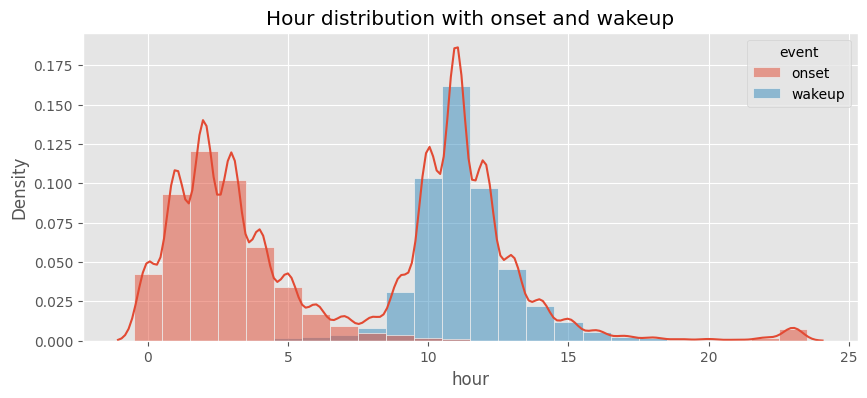

In [29]:
plt.figure(figsize=(10,4))
# plt.subplot(121)
plt.title('Hour distribution with onset and wakeup')
sns.histplot(x=train_events.dropna().hour, hue=train_events.dropna().event, stat='density', bins=24, binrange=(-0.5, 23.5))
sns.kdeplot(train_events.dropna().hour, bw_adjust=0.45)

<Axes: title={'center': 'day distribution with onset and wakeup'}, xlabel='day', ylabel='Density'>

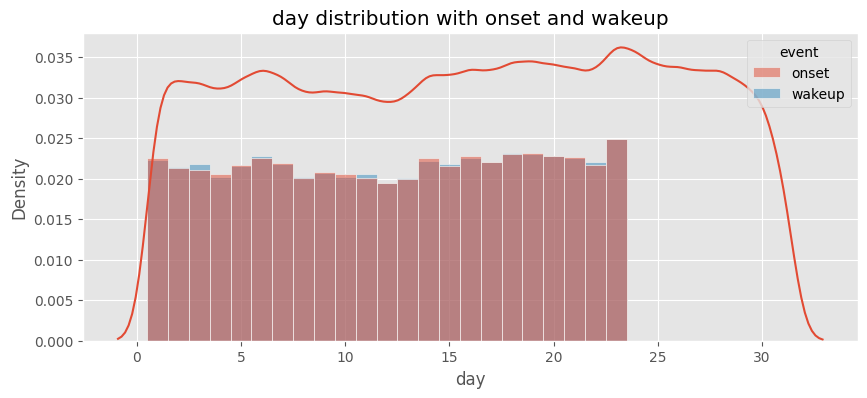

In [30]:
plt.figure(figsize=(10,4))
# plt.subplot(121)
plt.title('day distribution with onset and wakeup')
sns.histplot(x=train_events.dropna().day, hue=train_events.dropna().event, stat='density', bins=24, binrange=(-0.5, 23.5))
sns.kdeplot(train_events.dropna().day, bw_adjust=0.45)

<Axes: title={'center': 'month distribution with onset and wakeup'}, xlabel='month', ylabel='Density'>

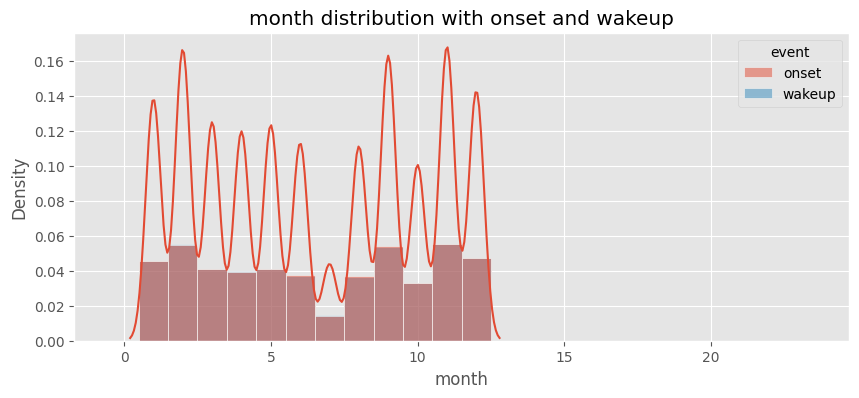

In [31]:
plt.figure(figsize=(10,4))
# plt.subplot(121)
plt.title('month distribution with onset and wakeup')
sns.histplot(x=train_events.dropna().month, hue=train_events.dropna().event, stat='density', bins=24, binrange=(-0.5, 23.5))
sns.kdeplot(train_events.dropna().month, bw_adjust=0.45)

In [32]:
mask_nonull= (~train_events['step'].isnull()) & (~train_events['timestamp'].isnull()) 
train_events_nonull = train_events[mask_nonull]

# Group by 'series_id' and calculate sleep duration for each night
sleep_duration_df = train_events_nonull.groupby([train_events_nonull['series_id'], train_events_nonull['night']])['timestamp'].agg(['min', 'max']).reset_index()
sleep_duration_df = sleep_duration_df.rename(columns={'min': 'onset', 'max': 'wakeup'})
sleep_duration_df['sleep_duration'] = ((sleep_duration_df['wakeup'] - sleep_duration_df['onset']).dt.seconds / 3600).round(0)

dfg = sleep_duration_df['sleep_duration'].value_counts().reset_index()
dfg.columns = ['sleep_duration', 'number_of_observations']
fig = px.bar(dfg, x='sleep_duration', y='number_of_observations', 
             title='Sleep hour distribution, Training seria (hours)'
            ) 
fig.show()

In [33]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   timestamp  object  
 1   series_id  category
 2   step       float32 
 3   anglez     float16 
 4   enmo       float16 
dtypes: category(1), float16(2), float32(1), object(1)
memory usage: 162.1+ MB


Text(0.5, 1.0, 'box plot for train series enmo data')

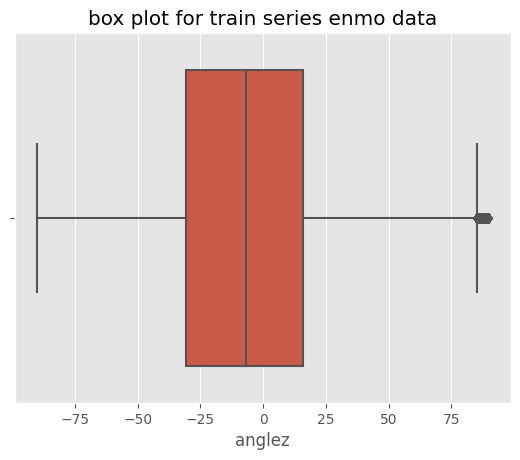

In [34]:
sns.boxplot(x = train_series['anglez'])
plt.title('box plot for train series enmo data')

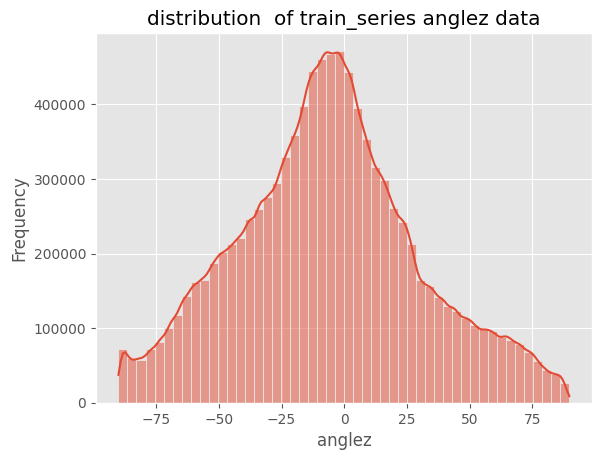

In [35]:
train_series['anglez'] = pd.to_numeric(train_series['anglez'], errors='coerce').astype('float32')

# Drop NaNs before plotting
sns.histplot(train_series['anglez'].dropna(), bins=50,kde = True )

# Plot labels
plt.title('distribution  of train_series anglez data')
plt.xlabel('anglez')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'box plot for train series enmo data')

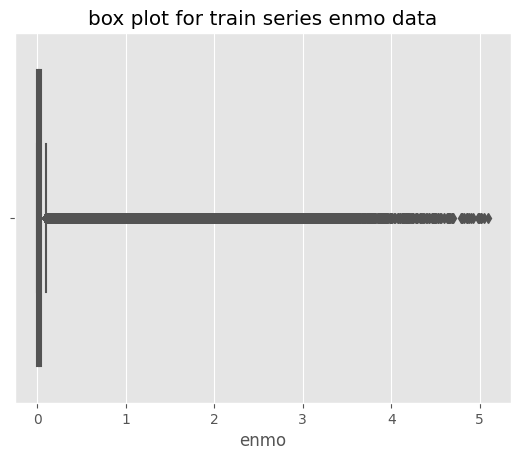

In [36]:
sns.boxplot(x = train_series['enmo'])
plt.title('box plot for train series enmo data')

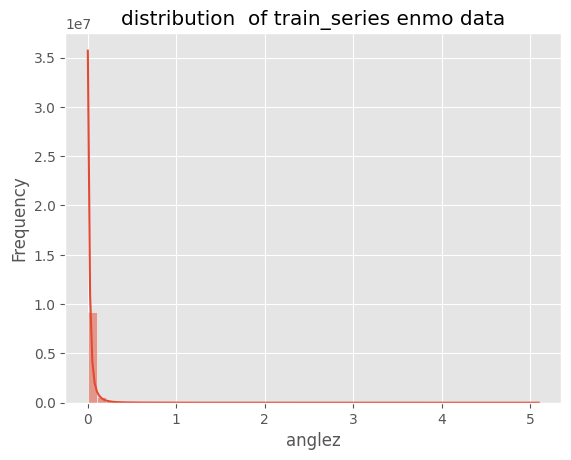

In [37]:
train_series['enmo'] = pd.to_numeric(train_series['enmo'], errors='coerce').astype('float32')

# Drop NaNs before plotting
sns.histplot(train_series['enmo'].dropna(), bins=50,kde = True )

# Plot labels
plt.title('distribution  of train_series enmo data')
plt.xlabel('anglez')
plt.ylabel('Frequency')
plt.show()

In [38]:
train_events

,timestamp,series_id,night,event,step,year,month,day,hour
0,2018-08-15 02:26:00+00:00,038441c925bb,1,onset,4992.0,2018,8,15,2
1,2018-08-15 10:41:00+00:00,038441c925bb,1,wakeup,10932.0,2018,8,15,10
2,2018-08-15 23:37:00+00:00,038441c925bb,2,onset,20244.0,2018,8,15,23
3,2018-08-16 09:41:00+00:00,038441c925bb,2,wakeup,27492.0,2018,8,16,9
4,2018-08-17 03:03:00+00:00,038441c925bb,3,onset,39996.0,2018,8,17,3
...,...,...,...,...,...,...,...,...,...
9580,2017-09-05 13:26:00+00:00,fe90110788d2,32,wakeup,547152.0,2017,9,5,13
9581,2017-09-06 02:30:00+00:00,fe90110788d2,33,onset,556560.0,2017,9,6,2
9582,2017-09-06 08:07:00+00:00,fe90110788d2,33,wakeup,560604.0,2017,9,6,8
9583,2017-09-07 03:35:00+00:00,fe90110788d2,34,onset,574620.0,2017,9,7,3


,count,mean,std,min,25%,50%,75%,max
tot_recorded_nights,269.0,21.375465,8.35077,1.0,17.0,22.0,25.0,43.0


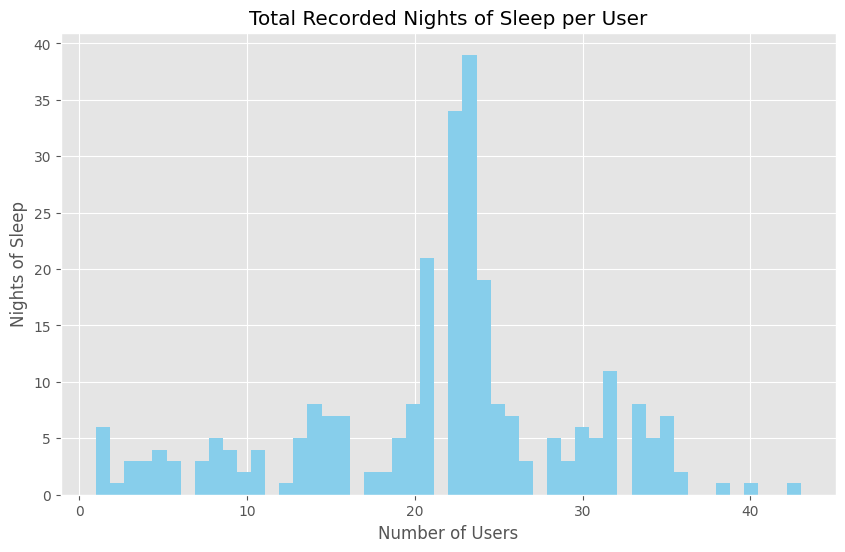

In [39]:
# Create 'missing_event' column: True if 'step' is missing, else False
train_events['missing_event'] = train_events['step'].isnull()

# Group by 'series_id' and aggregate
aggregated = train_events.groupby('series_id').agg(
    tot_events=('event', 'count'),
    tot_nights=('night', 'last'),
    tot_missing_events=('missing_event', 'sum')
).reset_index()

# Compute 'tot_missing_nights'
aggregated['tot_missing_nights'] = (aggregated['tot_missing_events'] // 2).astype('int32')

# Compute 'tot_recorded_events' and 'tot_recorded_nights'
aggregated['tot_recorded_events'] = aggregated['tot_events'] - aggregated['tot_missing_events']
aggregated['tot_recorded_nights'] = aggregated['tot_nights'] - aggregated['tot_missing_nights']

# Plot: Nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
aggregated['tot_recorded_nights'].hist(bins=50, ax=ax, color='skyblue')
ax.set_title('Total Recorded Nights of Sleep per User')
ax.set_ylabel('Nights of Sleep')
ax.set_xlabel('Number of Users')

# Describe the 'tot_recorded_nights' column
aggregated[['tot_recorded_nights']].describe().T


,count,mean,std,min,25%,50%,75%,max
tot_missing_nights,269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


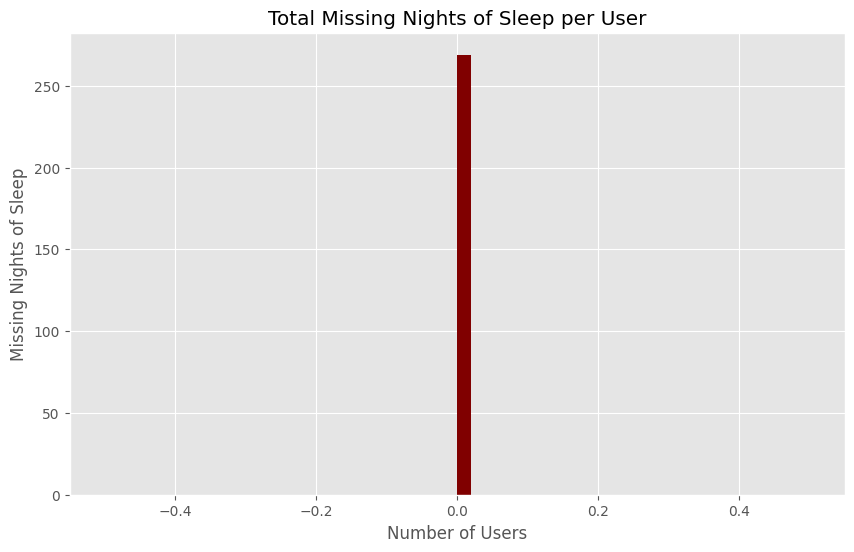

In [40]:
# Plot missing nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
aggregated['tot_missing_nights'].hist(bins=50, ax=ax, color='maroon')
ax.set_title('Total Missing Nights of Sleep per User')
ax.set_ylabel('Missing Nights of Sleep')
ax.set_xlabel('Number of Users')

# Describe
aggregated[['tot_missing_nights']].describe().T


A single sleep period must be at least 30 minutes in length



Windowing the training data


As the target is to detect an event, 


So, extracting timesteps 30 min before and after the events. 

In [41]:

def window(df, win_size):
    ind=df.index[df['event'].isna()==False]
    c=0
    df['window']=np.nan
    for i in tqdm(ind):
        a=i-win_size
        b=i+win_size
        df['window'].loc[a:i]=int(c)
        c=c+1
        df['window'].loc[i:b]=int(c)
        c=c+1
    df['window'].dropna(inplace=True)
    return df[df['window'].isna()==False]

    

Removing the steps where change in enmo and anglez is insignificant (device is supposed not to be worn).

In [42]:
def inactive_periods(df):
    print("shape before application: ",df.shape)
    df['diff_anglez']=df['anglez'].diff()
    df=df[(df['enmo']!=0.0) | (df['diff_anglez']!=0.0)]
    print("shape after application: ",df.shape)
    df.drop('diff_anglez', inplace=True, axis=1)
    print("shape after completion: ",df.shape)
    print("removed ")
    return df


CLUSTERING THE ENMO AND ANGELZ

In [43]:
def clustering(df):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler    
    X=df[['anglez','enmo']]
#Scalling the data
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(X)
#perform clustering
    model=KMeans(n_clusters=4,algorithm="elkan" )
    model.fit(X_scaled)
    return model.labels_


In [44]:
def rollingstd(series_df):
# Creating columns with nans
    series_df['sd_enmo_1']=np.nan    # 1 min rolling std: enmo
    series_df['sd_anglez_1']=np.nan  # 1 min rolling std: anglez
    series_df['m_enmo_2']=np.nan     # 2 min rolling mean: enmo
    series_df['m_anglez_2']=np.nan   # 2 min rolling std: anglez 
    print('anglez rolling std 12')
    series_df['sd_anglez_1'] = (series_df.groupby('series_id')['anglez']
                      .rolling(12)
                      .std()
                      .reset_index(level=0, drop=True))
    print('anglez rolling std 2')
    series_df['sd_anglez_1'][series_df['sd_anglez_1'].isna()==True] = (series_df.groupby('series_id')['anglez']
                      .rolling(2)
                      .std()
                      .reset_index(level=0, drop=True))
    print('enmo rolling std 12')
    series_df['sd_enmo_1'] = (series_df.groupby('series_id')['enmo']
                      .rolling(12)
                      .std()
                      .reset_index(level=0, drop=True))
    print('enmo rolling mean 24')
    series_df['m_enmo_2'] = (series_df.groupby('series_id')['enmo']
                      .rolling(24)
                      .mean()
                      .reset_index(level=0, drop=True))
    print('anglez rolling mean 24')
    series_df['m_anglez_2'] = (series_df.groupby('series_id')['anglez']
                      .rolling(24)
                      .mean()
                      .reset_index(level=0, drop=True))
    print('enmo rolling std 2')
    print('Nans in sd_emno_1: ',series_df['sd_enmo_1'].isnull().sum())
    series_df['sd_enmo_1'][series_df['sd_enmo_1'].isna()==True] = (series_df.groupby('series_id')['enmo']
                      .rolling(2)
                      .std()
                      .reset_index(level=0, drop=True))
    print('enmo rolling mean 2')
    series_df['m_enmo_2'][series_df['m_enmo_2'].isna()==True] = (series_df.groupby('series_id')['enmo']
                      .rolling(2)
                      .mean()
                      .reset_index(level=0, drop=True))
    print('anglez rolling mean 2')
    series_df['m_anglez_2'][series_df['m_anglez_2'].isna()==True] = (series_df.groupby('series_id')['anglez']
                      .rolling(2)
                      .mean()
                      .reset_index(level=0, drop=True))
#Series wise rolling std and mean
# filling rest of nans
    print('Nans in sd_emno_1: ',series_df['sd_enmo_1'].isnull().sum())
    series_df['sd_enmo_1'].fillna(0.0, inplace=True)
    series_df['sd_anglez_1'].fillna(0.0, inplace=True)
    series_df['m_enmo_2'].fillna(0.0, inplace=True)
    series_df['m_anglez_2'].fillna(0.0, inplace=True)
    print('Nans after removal: ',series_df['sd_enmo_1'].isnull().sum())

    return(series_df)

In [46]:
def scale(X):
    from sklearn import preprocessing
    scaler = preprocessing.StandardScaler().fit(X)
    return (scaler.transform(X))

In [47]:
df_series = train_series
df_events = train_events

In [48]:
print(type(df_series))  # should output: <class 'pandas.core.frame.DataFrame'>
print(type(df_events))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [49]:

# Merging the datasets
print('Merging the training datasets...')
events = df_events[['series_id', 'step', 'event']]
series_df = pd.merge(df_series, events, on=["step", "series_id"], how='left')
series_df['sleep']=np.nan
series_df.loc[series_df["event"]=="onset", "sleep"] = 1
series_df.loc[series_df["event"]=="wakeup", "sleep"] = 0
series_df['sleep'].fillna(method='ffill', inplace=True)
series_df['sleep'].fillna(value=0, inplace=True)
print('Datasets Merged...')
print('______________________________________')

# Removing the periods of inactivity
print('Removing the periods of Inactivity...')
series_df=inactive_periods(series_df)
print('______________________________________')

# Forming Windows
win_size=720  #60mins
print('Creating Windows each size: ',win_size)
series_df=window(series_df,win_size)
print('Windows formed...')
print('______________________________________')

# Adding the columns of Standard Deviation (1 min)
print('Adding columns to account for deviation in enmo and anglez 1 min rolling...')
series_df=rollingstd(series_df)
series_df['sd_anglez_1']=pd.to_numeric(series_df['sd_anglez_1'])
series_df['sd_enmo_1']=pd.to_numeric(series_df['sd_enmo_1'])
series_df['m_anglez_2']=pd.to_numeric(series_df['m_anglez_2'])
series_df['m_enmo_2']=pd.to_numeric(series_df['m_enmo_2'])
print('Std columns added...')
print('______________________________________')

# Clustering the Data
print('Clustering the data based on enmo and anglez...')
series_df['cluster']=(clustering(series_df)+1)/4
print('Added clusters...')

Merging the training datasets...
Datasets Merged...
______________________________________
Removing the periods of Inactivity...
shape before application:  (10000000, 7)
shape after application:  (8643738, 8)
shape after completion:  (8643738, 7)
removed 
______________________________________
Creating Windows each size:  720


100%|██████████| 509/509 [00:00<00:00, 3052.90it/s]


Windows formed...
______________________________________
Adding columns to account for deviation in enmo and anglez 1 min rolling...
anglez rolling std 12
anglez rolling std 2
enmo rolling std 12
enmo rolling mean 24
anglez rolling mean 24
enmo rolling std 2
Nans in sd_emno_1:  231
enmo rolling mean 2
anglez rolling mean 2
Nans in sd_emno_1:  21
Nans after removal:  0
Std columns added...
______________________________________
Clustering the data based on enmo and anglez...
Added clusters...


In [50]:
series_df.head()

,timestamp,series_id,step,anglez,enmo,event,sleep,window,sd_enmo_1,sd_anglez_1,m_enmo_2,m_anglez_2,cluster
4272,2018-08-14 21:26:00-04:00,038441c925bb,4272.0,-73.312500,0.042603,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.50
4273,2018-08-14 21:26:05-04:00,038441c925bb,4273.0,-1.091797,0.180908,NaN,0.0,0.0,0.097797,51.067749,0.111755,-37.202148,0.75
4274,2018-08-14 21:26:10-04:00,038441c925bb,4274.0,-19.390625,0.198364,NaN,0.0,0.0,0.012343,12.939225,0.189636,-10.241211,0.75
4275,2018-08-14 21:26:15-04:00,038441c925bb,4275.0,0.344482,0.094116,NaN,0.0,0.0,0.073715,13.954828,0.146240,-9.523071,0.75
4276,2018-08-14 21:26:20-04:00,038441c925bb,4276.0,-57.687500,0.163086,NaN,0.0,0.0,0.048769,41.034808,0.128601,-28.671509,0.75


In [51]:
series_df['cluster'].unique()

array([0.5 , 0.75, 0.25, 1.  ])

In [52]:
figure= px.imshow(series_df[['sd_anglez_1','sd_enmo_1','m_anglez_2','m_enmo_2','anglez','enmo','cluster','sleep']].corr(),text_auto=True, width=1200, height=1200)
figure.show()

In [53]:
from sklearn.model_selection import train_test_split
X=series_df[['sd_anglez_1','sd_enmo_1','anglez','m_anglez_2','m_enmo_2','enmo','cluster']]
y=series_df[['sleep']]
X_scaled=scale(X)
X_train, X_test, y_train, y_test =train_test_split(X_scaled,y,test_size=0.2, random_state=42)


In [54]:
X_train.shape

(492567, 7)

In [55]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(492567, 7) (492567, 1)
(123142, 7) (123142, 1)


In [56]:
X.to_csv('X_data.csv')

In [57]:
y.to_csv('y_data.csv')

In [58]:
series_df.to_csv('final_series_df.csv')

In [59]:
y_test[['sleep']].value_counts()

sleep
0.0      70073
1.0      53069
Name: count, dtype: int64

MACHINE LEARNING:

In [61]:
def evaluate(y_test,ypred):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("Accuracy: ",accuracy_score(y_test,y_pred)) 
    print("Precision Score : ", precision_score(y_test,y_pred)) #precision measures the proportion of true positive predictions among all positive instances. how many of survived predicted actually survived, doesn't verifies 0's 70 survived as preicted whereas actually 92 survived so 70/92 will be the precision.  if we predicted 70 survived, so presion will tell how many of those 70 predicted survived matches the actual row by row data. It checkes all positives and verifies if the answer is true for each row?
    print("Recall Score: ", recall_score(y_test,y_pred, average='macro')) #Recall measures the proportion of true positive predictions among all actual positive instalnces. If we predicted 100 survived correctly whereas actually 100 survived out of which 67 predicted correctly so recall will be 0.67
    print("F1 Score: ",f1_score(y_test,y_pred)) #mean of recall and precision
    cm = confusion_matrix(y_test, y_pred)
    figure= px.imshow(cm,text_auto=True, width=1200, height=1200)
    figure.show()


In [62]:
from sklearn.ensemble import RandomForestClassifier
rf =RandomForestClassifier(n_jobs=-1,verbose=1) 
print ('Training the model')
rf.fit(X_train,y_train)
print ('Saving the model')
from joblib import dump, load
dump(rf, 'rf_model.joblib')
y_pred=rf.predict(X_test)
evaluate(y_test,y_pred)

Training the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Saving the model


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


Accuracy:  0.9384369264751263
Precision Score :  0.9594376212023271
Recall Score:  0.9331649714451314
F1 Score:  0.9260916615483608


In [63]:
def evaluate_train_data(y_train, train_pred):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("Accuracy: ",accuracy_score(y_train, train_pred)) 
    print("Precision Score : ", precision_score(y_train, train_pred)) #precision measures the proportion of true positive predictions among all positive instances. how many of survived predicted actually survived, doesn't verifies 0's 70 survived as preicted whereas actually 92 survived so 70/92 will be the precision.  if we predicted 70 survived, so presion will tell how many of those 70 predicted survived matches the actual row by row data. It checkes all positives and verifies if the answer is true for each row?
    print("Recall Score: ", recall_score(y_train, train_pred, average='macro')) #Recall measures the proportion of true positive predictions among all actual positive instalnces. If we predicted 100 survived correctly whereas actually 100 survived out of which 67 predicted correctly so recall will be 0.67
    print("F1 Score: ",f1_score(y_train, train_pred)) #mean of recall and precision
    cm = confusion_matrix(y_train, train_pred)
    figure= px.imshow(cm,text_auto=True, width=1200, height=1200)
    figure.show()


In [64]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [65]:
evaluate_train_data(y_train, train_pred)

Accuracy:  0.999809163017417
Precision Score :  0.9995806950097995
Recall Score:  0.9998295124224126
F1 Score:  0.9997785254507243


In [66]:
from sklearn.metrics import accuracy_score

In [67]:
def check_model_fit(train_acc, test_acc):
    print(f"\n Train Accuracy: {train_acc:.4f}")
    print(f" Test Accuracy:  {test_acc:.4f}")
    if train_acc > 0.95 and (train_acc - test_acc) > 0.1:
        print(" Model is likely OVERFITTING.")
    elif train_acc < 0.70 and test_acc < 0.70:
        print(" Model is likely UNDERFITTING.")
    else:
        print(" Model is likely a GOOD FIT.")
check_model_fit(
    train_acc=accuracy_score(y_train, train_pred),
    test_acc=accuracy_score(y_test, test_pred)
)


 Train Accuracy: 0.9998
 Test Accuracy:  0.9384
 Model is likely a GOOD FIT.


In [68]:
print('Removing the periods of Inactivity...')
test_series = inactive_periods(test_series)
print('______________________________________')

print('Adding Features...')
test_series = rollingstd(test_series)
test_series['sd_anglez_1'] = pd.to_numeric(test_series['sd_anglez_1'])
test_series['sd_enmo_1'] = pd.to_numeric(test_series['sd_enmo_1'])
test_series['m_anglez_2'] = pd.to_numeric(test_series['m_anglez_2'])
test_series['m_enmo_2'] = pd.to_numeric(test_series['m_enmo_2'])
print('Features added...')
print('______________________________________')

print('Clustering the data based on enmo and anglez...')
test_series['cluster'] = (clustering(test_series) + 1) / 4
print('Added clusters...')

X_test = test_series[['sd_anglez_1', 'sd_enmo_1', 'anglez', 'm_anglez_2', 'm_enmo_2', 'enmo', 'cluster']]
y_pred = rf.predict(scale(X_test))
X_test = []


Removing the periods of Inactivity...
shape before application:  (450, 4)
shape after application:  (322, 5)
shape after completion:  (322, 4)
removed 
______________________________________
Adding Features...
anglez rolling std 12
anglez rolling std 2
enmo rolling std 12
enmo rolling mean 24
anglez rolling mean 24
enmo rolling std 2
Nans in sd_emno_1:  33
enmo rolling mean 2
anglez rolling mean 2
Nans in sd_emno_1:  3
Nans after removal:  0
Features added...
______________________________________
Clustering the data based on enmo and anglez...
Added clusters...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [69]:
test_series.reset_index(inplace = True)

In [70]:
result_df=test_series[['series_id', 'step','timestamp']]
result_df['sleep']=y_pred
result_df['timestamp']=result_df[['timestamp']].progress_apply(lambda x: pd.to_datetime(x,utc=True))
df=result_df.copy()
df.index=df['timestamp']
mean = df.groupby([df['series_id'], df.index.floor('5min')])['sleep'].mean()  # Calculating the mean of predictions over an interval of 5 mins (Due to the nature of Testing Data Series). 
mean=mean.reset_index()
mean['timestamp']=mean['timestamp']- pd.to_timedelta('5m') # Since the event is recorded at the end of the interval so subtracting 5 mins (Due to the nature of Testing Data Series) so it records the event at the start of the interval
summary=pd.merge(result_df,mean,on=["timestamp","series_id"],how='left')  # merging the means into the original data based on timestamps and series ID.
summary=summary[summary['sleep_y'].isna()==False]  # removing the Nan's of prediction mean. That'll ensure that we have a row every 5 mins (Due to the nature of Testing Data Series).
# Creating Event Column
summary['event']=np.nan
summary.loc[summary["sleep_y"]==1, "event"] = 'onset'  # the mean prediction will be 1 if predicted onset for 30 mins consecutive
summary.loc[summary["sleep_y"]==0, "event"] = 'wakeup' # the mean prediction will be 0 if predicted wakeup for 30 mins consecutive. Any duration in between will be considered disturbance as will be less tan 30 mins.
summary=summary[summary['event'].isna()==False] # Removing the rows with no event recorded. 
submission=summary[['series_id','step','event','sleep_y']]  # Creating Submission
submission = submission.rename(columns={'sleep_y': 'score'})  # Renaming a column

submission.to_csv('submission.csv')  # Saving the csv file

100%|██████████| 1/1 [00:00<00:00, 584.33it/s]


In [71]:
submission

,series_id,step,event,score
0,038441c925bb,0.0,onset,1.0
60,038441c925bb,60.0,onset,1.0
172,0402a003dae9,0.0,wakeup,0.0
232,0402a003dae9,60.0,wakeup,0.0
